In [1]:
%load_ext autoreload
%autoreload 2
# lib and settings for interactive plots
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)
    # figsize=(5, 4)
import matplotlib.pyplot as plt

import numpy as np
import math
import pandas as pd
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow.keras import layers
import keras.callbacks

from itertools import product
import os
base_folder = os.path.join(os.getcwd(), '..')

2023-02-16 09:27:56.437579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 09:27:56.836286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-16 09:27:56.836379: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-16 09:27:59.078441: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
from tqdm import tqdm

# Data Inspection

In [3]:
def milstein_method(theta, sigma, delta_t, x0=1, N=1000):
    # TODO: check parameter mu
    X = np.zeros(N)
    X[0] = x0
    W = np.random.normal(0, 1, size=N)
    W[0] = 0
    for i in range(N-1):
        X[i+1] = X[i] + theta*(1 - X[i])*delta_t + sigma*W[i]*X[i]*np.sqrt(delta_t) + 0.5*(sigma**2)*X[i]*delta_t*(W[i]**2 - 1)
    return X

In [45]:
params

{'run': 30,
 'sigma': [0.3, 0.4, 0.5, 0.6],
 'theta': [0.01, 0.1, 0.5, 3],
 'delta': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
 'N': 1000}

In [59]:
def plot_datapoints(grid, params, run=0, theta=0.1, sigma=0.5, delta=0.2, variation=None, num_run=10):
    assert run in range(params['run'])
    assert variation in list(params.keys())+[None]
    # TODO: prepare labels in function of different parameters in order to plot also the plot legend
    sigma = params['sigma'].index(sigma)
    theta = params['theta'].index(theta)
    delta = params['delta'].index(delta)
    plt.figure(figsize=figsize)
    if variation is None:
        Xs = grid[run, sigma, theta, delta, :]
        plt.plot(Xs)
    else:
        if variation == 'theta':
            Xs = grid[run, sigma, :, delta, :]
        elif variation == 'sigma':
            Xs = grid[run, :, theta, delta, :]
        elif variation == 'delta':
            Xs = grid[run, sigma, theta, :, :]
        elif variation == 'run':
            Xs = grid[:num_run, sigma, theta, delta, :]
        labels = [variation+' = '+str(p) for p in params[variation]]
        for X, l in zip(Xs, labels):
            plt.plot(X, label = l)
    plt.xlabel('t')
    plt.ylabel('X(t)')
    plt.legend()
    plt.show()


In [5]:
theta_list   = [0.01, 0.1, 0.5, 3]
theta_colors = ['g', 'r', 'b', 'm']

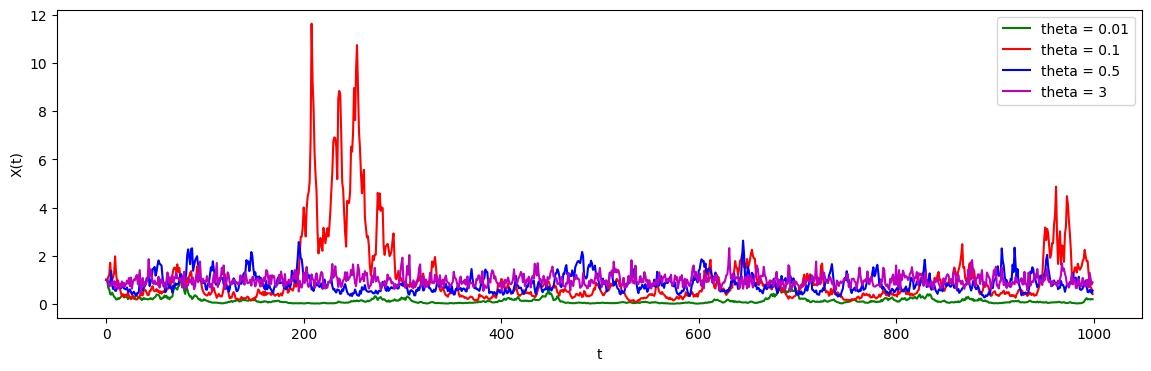

In [6]:
plt.figure(figsize=figsize)
for theta, color in zip(theta_list, theta_colors):
    X = milstein_method(theta, 0.5, 0.2)
    plt.plot(X, label = "theta = " + str(theta), color=color)
plt.xlabel('t')
plt.ylabel('X(t)')
plt.legend()
plt.show()

## Parameter grid

In [7]:
params = {
    'run': 30,
    'sigma': [0.3, 0.4, 0.5, 0.6],
    'theta': [0.01, 0.1, 0.5, 3],
    # 'mu': [0.8, 0.9, 1, 1.1],
    'delta': [0.01,0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
    'N': 1000
}

In [8]:
grid = np.zeros((params['run'], 
                 len(params['sigma']),
                 len(params['theta']),
                 # len(params['mu']),
                 len(params['delta']),
                 params['N']))

In [11]:
for r in tqdm(range(params['run'])):
    for s, t, d in product(params['sigma'], params['theta'],params['delta']):
        # TODO: just in case add also mu 
        si = params['sigma'].index(s)
        ti = params['theta'].index(t)
        di = params['delta'].index(d)
        grid[r,si,ti,di,:] = milstein_method(t,s,d)

100%|██████████| 30/30 [00:17<00:00,  1.74it/s]


store and load data grid

In [ ]:
# store grid data
grid_path = os.path.join(base_folder, 'Data', 'grid')
np.save(grid_path, grid, allow_pickle=True)
# load grid data
grid1 = np.load(grid_path+'.npy', allow_pickle=True)
grid1[0,0,0,0,:]

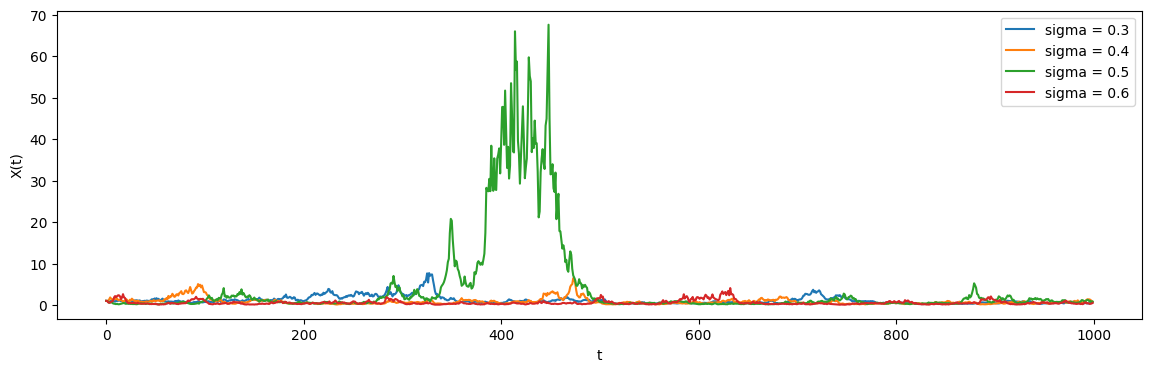

In [67]:
#
# plot_datapoints(grid, params, sigma=0.3, theta=0.01, delta=0.01, variation='sigma')
plot_datapoints(grid, params, run=1, variation='sigma')

### mean and dev std

In [75]:
# media su run
np.mean(grid, axis=0).shape
np.std(grid, axis=0).shape

(4, 4, 10, 1000)

In [77]:
# media su istanti temporali
np.mean(grid, axis=-1).shape
np.std(grid, axis=-1).shape

(30, 4, 4, 10)

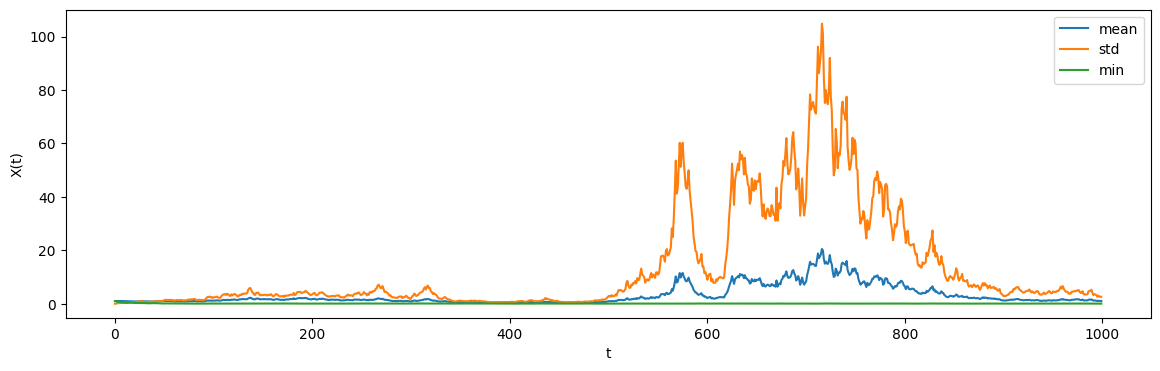

In [87]:
# np.mean(grid, axis=0)[0,0,:]
plt.figure(figsize=figsize)
plt.plot(np.mean(grid, axis=0)[0,0,3,:], label='mean')
plt.plot( np.std(grid, axis=0)[0,0,3,:], label='std')
plt.plot( np.min(grid, axis=0)[0,0,3,:], label='min')
plt.xlabel('t')
plt.ylabel('X(t)')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


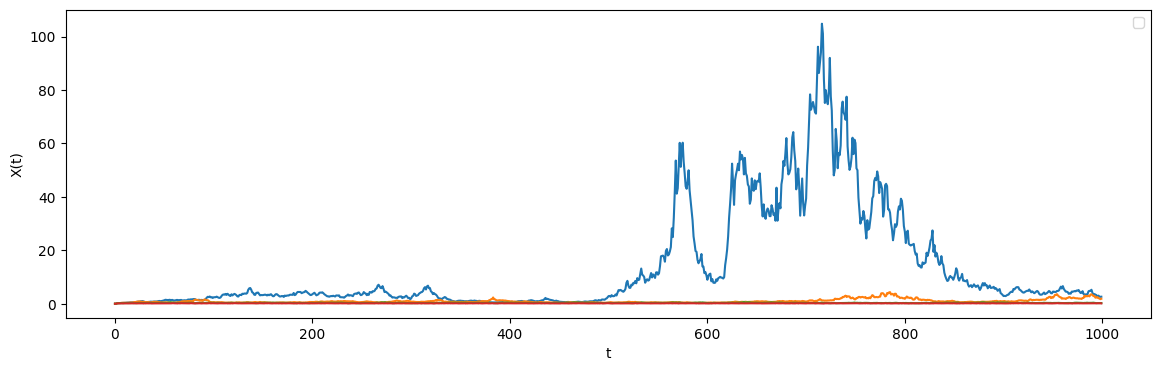

In [78]:
# np.mean(grid, axis=0)[0,0,:]
plt.figure(figsize=figsize)
plt.plot(np.std(grid, axis=0)[0,0,3,:])
plt.plot(np.std(grid, axis=0)[0,1,3,:])
plt.plot(np.std(grid, axis=0)[0,2,3,:])
plt.plot(np.std(grid, axis=0)[0,3,3,:])
plt.xlabel('t')
plt.ylabel('X(t)')
plt.legend()
plt.show()

L'istante di tempo non ci dice nulla sullo spike, ma ce lo dovrebbe dire l'istante precedente allo spike.

Se iniziano a crescere probabilmente c'è lo spike

In [ ]:
np.mean(grid, axis=-1)